# 6장. 종 분포 모델링: GEE를 활용한 서식지 예측 및 분석

## 6.2. GEE를 활용한 서식지 예측 및 분석

###  6.2.1. 종 출현 데이터 수집 및 처리

In [ ]:
# 라이브러리 설치
%pip install -U -q pyarrow
%pip install -U -q geopandas
%pip install -U -q pycrs
%pip install -U -q statsmodels

In [1]:
# 라이브러리 호출
import ee
import geemap

import geemap.colormaps as cm
import pandas as pd, geopandas as gpd
import numpy as np, matplotlib.pyplot as plt
import os, requests, math, random

from ipyleaflet import TileLayer
from statsmodels.stats.outliers_influence \
    import variance_inflation_factor

In [2]:
ee.Initialize(project='ee-foss4g')

In [8]:
# GBIF API 파라미터 설정
species_name = "Pitta nympha" # 학명
country_code = "KR" # 국가코드
base_url = "https://api.gbif.org/v1/occurrence/search"
params = {
    "scientificName": species_name, # 학명
    "country": country_code, # 국가
    "hasCoordinate": "true", # 좌표 유무
    "basisOfRecord": "HUMAN_OBSERVATION", # 인간에 의한 관측
    "limit": 10000, # 최대 10,000개 결과 반환
}

In [15]:
# GBIF API 호출
response = requests.get(base_url, params=params)
data = response.json() # dict
occurrences = data["results"] # list

# List를 DataFrame으로 변환
df = pd.json_normalize(occurrences)
df.head(1)

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,verbatimElevation,behavior,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa,lifeStage,occurrenceRemarks
0,4126765284,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2024-01-16T15:19:45.976+00:00,2024-01-16T23:36:41.960+00:00,429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# DataFrame을 CSV로 저장
df.to_csv("pitta_nympha_data.csv", index=False)
df = pd.read_csv("pitta_nympha_data.csv")
df.head(1)

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,verbatimElevation,behavior,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa,lifeStage,occurrenceRemarks
0,4126765284,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2024-01-16T15:19:45.976+00:00,2024-01-16T23:36:41.960+00:00,429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# DataFrame을 GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude,
                                df.decimalLatitude),
    crs="EPSG:4326"
)[["species", "year", "month", "geometry"]]
gdf.head(1)

,species,year,month,geometry
0,Pitta nympha,2023,5,POINT (126.72514 33.20314)


In [19]:
# GeoDataFrame을 GeoPackage로 변환
gdf.to_file("pitta_nympha_data.gpkg", driver="GPKG")
gdf = gpd.read_file("pitta_nympha_data.gpkg")
gdf.head(1)

,species,year,month,geometry
0,Pitta nympha,2023,5,POINT (126.72514 33.20314)


In [23]:
# 연도(year)와 월별(month) 데이터 분포 시각화
def plot_data_distribution(gdf, h_size=12):

    plt.figure(figsize=(h_size, h_size-8))
    
    # 연도별 데이터 분포 그래프 (왼쪽)
    plt.subplot(1, 2, 1)
    year_counts = gdf['year'].value_counts().sort_index()    
    plt.bar(year_counts.index, year_counts.values)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Yearly Data Distribution')

    # 막대 그래프 안에 데이터 개수 표시
    for i, count in enumerate(year_counts.values):
        plt.text(year_counts.index[i], count, str(count), ha='center', va='bottom')

    # 월별 데이터 분포 그래프 (오른쪽)
    plt.subplot(1, 2, 2)
    month_counts = gdf['month'].value_counts().sort_index()
    plt.bar(month_counts.index, month_counts.values)
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.title('Monthly Data Distribution')

    # 막대 그래프 안에 데이터 개수 표시
    for i, count in enumerate(month_counts.values):
        plt.text(month_counts.index[i], count, str(count), ha='center', va='bottom')
    
    # x 축의 눈금을 정수 형식으로 설정
    plt.xticks(month_counts.index, map(int, month_counts.index))
    
    # 그래프 출력
    plt.tight_layout()
    plt.savefig('data_distribution_plot.png')
    plt.show()

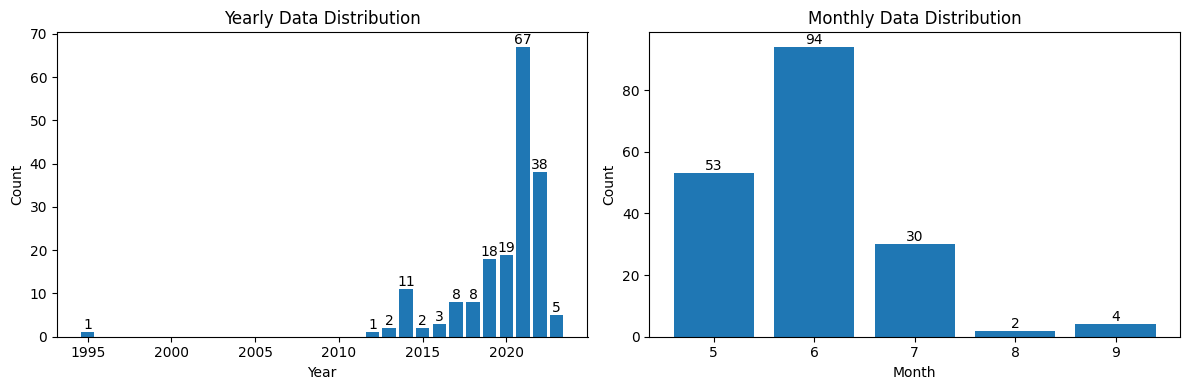

In [21]:
plot_data_distribution(gdf)

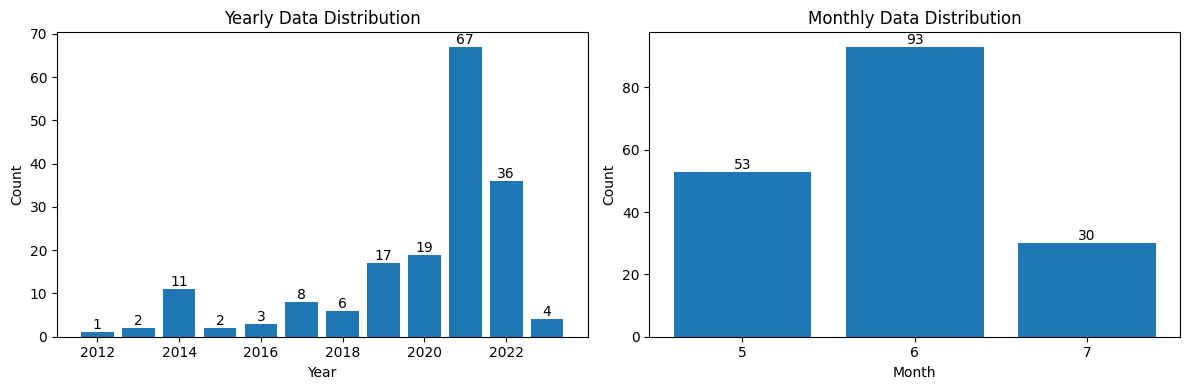

In [24]:
# 연도와 월별 데이터 필터링
filtered_gdf = gdf[
    (~gdf['year'].eq(1995)) &
    (~gdf['month'].between(8, 9))
]

plot_data_distribution(filtered_gdf)

In [25]:
# 연도(year)와 월별(month) 데이터 분포 히트맵
def plot_heatmap(gdf, h_size=8):

    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)

    # 히트맵
    plt.figure(figsize=(h_size, h_size-6))
    heatmap = plt.imshow(statistics.values, cmap="YlOrBr", origin="upper", aspect="auto")

    # 각 픽셀 위에 수치 표시
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(j, i, statistics.values[i, j], ha="center", va="center", color="black")

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig('heatmap_plot.png')
    plt.show()
    print(gdf.groupby(["month", "year"]).size().unstack(fill_value=0))

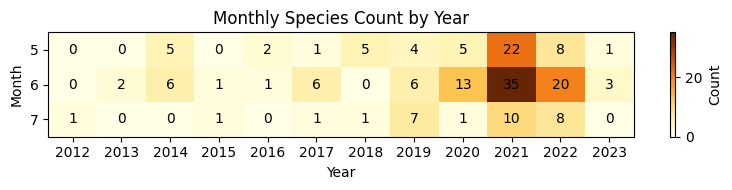

year   2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023
month                                                                        
5         0     0     5     0     2     1     5     4     5    22     8     1
6         0     2     6     1     1     6     0     6    13    35    20     3
7         1     0     0     1     0     1     1     7     1    10     8     0


In [26]:
plot_heatmap(filtered_gdf)

In [30]:
# GeoDataFrame을 Earth Engine 객체로 변환
data_raw = geemap.geopandas_to_ee(filtered_gdf)

In [31]:
# GeoDataFrame을 Shapefile로 저장
output_shapefile = 'pitta_nympha_data.shp'
filtered_gdf.to_file(output_shapefile)

# Shapefile을 GEE 객체로 변환
data_raw = geemap.shp_to_ee(output_shapefile)

In [32]:
# 공간 해상도 설정(m)
GrainSize = 1000

In [33]:
def remove_duplicates(data, GrainSize):
    # 선택한 공간 해상도(1km)에서 픽셀 당 출현 기록 하나만 무작위 선택
    random_raster = ee.Image.random().reproject('EPSG:4326', None, GrainSize)
    rand_point_vals = random_raster.sampleRegions(collection=ee.FeatureCollection(data), scale=10, geometries=True)
    return rand_point_vals.distinct('random')

In [34]:
Data = remove_duplicates(data_raw, GrainSize)

# 선택 전, 선택 후
print('Original data size:', data_raw.size().getInfo())
print('Final data size:', Data.size().getInfo())

Original data size: 176
Final data size: 111


In [44]:
# 지리적 샘플링 편향의 전처리 전(파란색)과 후(빨간색) 가시화
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

Vworld_Base = TileLayer(
    url='https://xdworld.vworld.kr/2d/Base/service/{z}/{x}/{y}.png',
    name='Vworld Base',
    attribution='Vworld',
    shown=True
)
Map.add_layer(Vworld_Base)

Map.addLayer(data_raw, {'color': 'blue'}, 'Original data')
Map.addLayer(Data, {'color': 'red'}, 'Final data')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.533064630393035, 126.8858638222748], controls=(WidgetControl(options=['position', 'transparent_…

### 6.2.2. 관심 영역 정의

In [46]:
# AOI 정의
AOI = Data.geometry().bounds().buffer(
    distance=50000, maxError=1000)

# 연구지역 경계를 지도에 추가
outline = ee.Image().byte().paint(
    featureCollection=AOI, color=1, width=3)

Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(AOI, 6)
Map

Map(bottom=6657.0, center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position'…

### 6.2.3. GEE 환경 변수 추가

In [48]:
# WorldClim V1 Bioclim
BIO = ee.Image("WORLDCLIM/V1/BIO")

In [49]:
# NASA SRTM Digital Elevation 30m
Terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

In [57]:
# Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m
TCC = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
MedianTCC = TCC.filterDate('2000-01-01', '2015-12-31')
MedianTCC = MedianTCC.select(['tree_canopy_cover'], ['TCC']).median()

In [59]:
# 밴드들을 하나의 다중 밴드 이미지로 결합
predictors = BIO.addBands(Terrain).addBands(MedianTCC)

# 수역 마스크 생성
watermask =  Terrain.select('elevation').gt(0)

# 해양 픽셀 마스킹 및 관심 영역 클리핑
predictors = predictors.updateMask(watermask).clip(AOI)

In [60]:
# 5000개 임의 지점에서 다중 밴드 예측 이미지 간 공변량 값 추출
# 5000개 임의 지점 생성
DataCor = predictors.sample(scale=GrainSize, numPixels=5000, geometries=True)
# 공변량 값 추출
PixelVals = predictors.sampleRegions(collection=DataCor, scale=GrainSize, tileScale=16)

In [53]:
PixelVals_df = geemap.ee_to_df(PixelVals)
PixelVals_df.head(1)

,TCC,aspect,bio01,bio02,bio03,bio04,bio05,bio06,bio07,bio08,...,bio13,bio14,bio15,bio16,bio17,bio18,bio19,elevation,hillshade,slope
0,9.0,288,140,89,26,8572,304,-26,330,246,...,215,32,63,561,111,539,111,28,187,2


In [ ]:
columns = PixelVals_df.columns
print(columns)

In [ ]:
def plot_correlation_heatmap(dataframe, h_size=10):

    correlation_matrix = dataframe.corr(method="spearman")

    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                     ha='center', va='center', color='white', fontsize=8)

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables correlation matrix")
    plt.colorbar(label="Spearman Correlation")
    plt.savefig('correlation_heatmap_plot.png')
    plt.show()

In [ ]:
plot_correlation_heatmap(PixelVals_df)

In [ ]:
def filter_variables_by_vif(dataframe, threshold=10):
    
    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]
    
    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
        
        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)
        
        if max_vif < threshold:
            break
        
        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")
        
        del remaining_columns[max_vif_index]
    
    filtered_data = dataframe[remaining_columns]
    bands = filtered_data.columns.tolist()
    print('Bands:', bands)
    
    return filtered_data, bands

In [ ]:
filtered_PixelVals_df, bands = filter_variables_by_vif(PixelVals_df)

In [ ]:
predictors = predictors.select(bands)
plot_correlation_heatmap(filtered_PixelVals_df, h_size=6)

In [ ]:
cm.plot_colormaps(width=8.0, height=0.2)

In [ ]:
cm.plot_colormap('terrain', width=8.0, height=0.2, orientation='horizontal')

In [ ]:
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['elevation'], 'min': 0, 'max': 1800, 'palette': cm.palettes.terrain}
Map.addLayer(predictors, vis_params, 'elevation')
Map.add_colorbar(vis_params, label="Elevation (m)", orientation="vertical", layer_name="elevation")
Map.centerObject(AOI, 6)
Map

In [ ]:
min_val = predictors.select("bio09").multiply(0.1).reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
max_val = predictors.select("bio09").multiply(0.1).reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'min': math.floor(min_val['bio09']), 'max': math.ceil(max_val['bio09']), 'palette': cm.palettes.hot}
Map.addLayer(predictors.select("bio09").multiply(0.1), vis_params, 'bio09')
Map.add_colorbar(vis_params, label="Mean temperature of driest quarter (℃)", orientation="vertical", layer_name="bio09")
Map.centerObject(AOI, 6)
Map

In [ ]:
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['slope'], 'min': 0, 'max': 25, 'palette': cm.palettes.RdYlGn_r}
Map.addLayer(predictors, vis_params, 'slope')
Map.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")
Map.centerObject(AOI, 6)
Map

In [ ]:
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['aspect'], 'min': 0, 'max': 360, 'palette': cm.palettes.rainbow}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(AOI, 6)
Map

In [ ]:
min_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
max_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)
vis_params = {'bands':['bio14'], 'min': math.floor(min_val['bio14']), 'max': math.ceil(max_val['bio14']), 'palette': cm.palettes.Blues}
Map.addLayer(predictors, vis_params, 'bio14')
Map.add_colorbar(vis_params, label="Precipitation of driest month (mm)", orientation="vertical", layer_name="bio14")
Map.centerObject(AOI, 6)
Map

In [ ]:
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['TCC'], 'min': 0, 'max': 100, 'palette': ['ffffff', 'afce56', '5f9c00', '0e6a00', '003800']}
Map.addLayer(predictors, vis_params, 'TCC')
Map.add_colorbar(vis_params, label="Tree Canopy Cover (%)", orientation="vertical", layer_name="TCC")
Map.centerObject(AOI, 6)
Map

### 6.2.4. 임의-비출현 데이터 생성

In [ ]:
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None, ee.Number(GrainSize)).mask().neq(1).selfMask()

In [ ]:
PixelVals = predictors.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(100),
    properties=[],
    tileScale=16,
    scale=GrainSize
)

In [ ]:
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(PixelVals)

Clresult = predictors.cluster(clusterer)

clustID = Clresult.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(200),
    properties=[],
    tileScale=16,
    scale=GrainSize
)
clustID = ee.FeatureCollection(clustID).reduceColumns(ee.Reducer.mode(),['cluster'])
clustID = ee.Number(clustID.get('mode')).subtract(1).abs()
cl_mask = Clresult.select(['cluster']).eq(clustID)

In [ ]:
AreaForPA = presence_mask.updateMask(cl_mask).clip(AOI)

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(AOI, 6)
Map

### 6.2.5. 모델 적합 및 예측

In [ ]:
def makeGrid(geometry, scale):
    
    lonLat = ee.Image.pixelLonLat()
    lonGrid = lonLat.select('longitude').multiply(100000).toInt()
    latGrid = lonLat.select('latitude').multiply(100000).toInt()
    
    return lonGrid.multiply(latGrid).reduceToVectors(
        geometry = geometry.buffer(distance=20000, maxError=1000),
        scale = scale,
        geometryType = 'polygon'
    )

In [ ]:
Scale = 50000
grid = makeGrid(AOI, Scale)
Grid = watermask.reduceRegions(
    collection=grid,
    reducer=ee.Reducer.mean()).filter(ee.Filter.neq('mean', None))

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)
Map.addLayer(Grid, {}, "Grid for spatial block cross validation")
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(AOI, 6)
Map

In [ ]:
def SDM(x):
    Seed = ee.Number(x)

    GRID = ee.FeatureCollection(Grid).randomColumn(seed=Seed).sort('random')
    TrainingGrid = GRID.filter(ee.Filter.lt('random', split))
    TestingGrid = GRID.filter(ee.Filter.gte('random', split))
    
    PresencePoints = ee.FeatureCollection(Data)
    PresencePoints = PresencePoints.map(lambda feature: feature.set('PresAbs', 1))
    TrPresencePoints = PresencePoints.filter(ee.Filter.bounds(TrainingGrid))
    TePresencePoints = PresencePoints.filter(ee.Filter.bounds(TestingGrid))
    
    TrPseudoAbsPoints = AreaForPA.sample(region=TrainingGrid,
                                         scale=GrainSize,
                                         numPixels=TrPresencePoints.size().add(300),
                                         seed=Seed,
                                         geometries=True)
    TrPseudoAbsPoints = TrPseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TrPresencePoints.size()))
    TrPseudoAbsPoints = TrPseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))
    
    TePseudoAbsPoints = AreaForPA.sample(region=TestingGrid,
                                         scale=GrainSize,
                                         numPixels=TePresencePoints.size().add(100),
                                         seed=Seed,
                                         geometries=True)
    TePseudoAbsPoints = TePseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TePresencePoints.size()))
    TePseudoAbsPoints = TePseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))

    trainingPartition = TrPresencePoints.merge(TrPseudoAbsPoints)
    testingPartition = TePresencePoints.merge(TePseudoAbsPoints)

    trainPixelVals = predictors.sampleRegions(collection=trainingPartition,
                                              properties=['PresAbs'],
                                              scale=GrainSize,
                                              tileScale=16,
                                              geometries=True)

    Classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=500,
        variablesPerSplit=None,
        minLeafPopulation=10,
        bagFraction=0.5,
        maxNodes=None,
        seed=Seed
    )
    
    ClassifierPr = Classifier.setOutputMode('PROBABILITY').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgPr = predictors.select(bands).classify(ClassifierPr)
    
    ClassifierBin = Classifier.setOutputMode('CLASSIFICATION').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgBin = predictors.select(bands).classify(ClassifierBin)

    return [ClassifiedImgPr, ClassifiedImgBin, trainingPartition, testingPartition], ClassifierPr

In [ ]:
split = 0.7
numiter = 10

In [ ]:
runif = lambda length: [random.randint(1, 1000) for _ in range(length)]

items = runif(numiter)
# items = [287, 288, 553, 226, 151, 255, 902, 267, 419, 538]

results_list = []
importances_list = []

for item in runif(numiter):
    result, trained = SDM(item)

    results_list.extend(result)

    importance = ee.Dictionary(trained.explain()).get('importance')
    importances_list.extend(importance.getInfo().items())

results = ee.List(results_list).flatten()

In [ ]:
images = ee.List.sequence(0, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x))
ModelAverage = ee.ImageCollection.fromImages(images).mean()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['#440154', '#482677', '#404788', '#33638D', '#287D8E',
          '#1F968B', '#29AF7F', '#55C667', '#95D840', '#DCE319']}
Map.addLayer(ModelAverage, vis_params, 'Habitat suitability')
Map.add_colorbar(vis_params, label="Habitat suitability", orientation="horizontal", layer_name="Habitat suitability")
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.centerObject(AOI, 6)
Map

In [ ]:
images2 = ee.List.sequence(1, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x))
DistributionMap = ee.ImageCollection.fromImages(images2).mode()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map.addLayer(DistributionMap, vis_params, 'Potential distribution')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution", discrete=True, orientation="horizontal", layer_name="Potential distribution")
Map.centerObject(Data.geometry(), 7)
Map

In [ ]:
variables = [item[0] for item in importances_list]
importances = [item[1] for item in importances_list]

average_importances = {}
for variable in set(variables):
    indices = [i for i, var in enumerate(variables) if var == variable]
    average_importance = np.mean([importances[i] for i in indices])
    average_importances[variable] = average_importance

for variable, avg_importance in average_importances.items():
    print(f"{variable}: {avg_importance}")

In [ ]:
sorted_importances = sorted(average_importances.items(), key=lambda x: x[1], reverse=False)
variables = [item[0] for item in sorted_importances]
avg_importances = [item[1] for item in sorted_importances]

plt.figure(figsize=(8, 4))  # Resize as desired

plt.barh(variables, avg_importances)
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.title('Average Variable Importance')

for i, v in enumerate(avg_importances):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center')

plt.xlim(0, max(avg_importances) + 5)

plt.tight_layout()
plt.savefig('variable_importance_plot.png')
plt.show()

### 6.2.6. 변수 중요도 및 정확도 평가

In [ ]:
# Extract the validation dataset
TestingDatasets = (ee.List.sequence(3, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x)))

# Check if there are enough occurrences and randomly non-occurrence points for model validation
def get_sizes(x):
    fc = ee.FeatureCollection(TestingDatasets.get(x))
    presence_size = fc.filter(ee.Filter.eq('PresAbs', 1)).size()
    pseudo_absence_size = fc.filter(ee.Filter.eq('PresAbs', 0)).size()
    return ee.List([presence_size, pseudo_absence_size])

print('Number of presence and pseudo-absence points for model validation',
      ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(get_sizes).getInfo())

In [ ]:
%%time

# Estimate sensitivity, specificity, and precision
def getAcc(img, TP, GrainSize=GrainSize):
    Pr_Prob_Vals = img.sampleRegions(collection=TP, properties=['PresAbs'], scale=GrainSize, tileScale=16)   
    seq = ee.List.sequence(start=0, end=1, count=25)
    def calculate_metrics(cutoff):
        Pres = Pr_Prob_Vals.filterMetadata('PresAbs', 'equals', 1)
        # Sensitivity: True Positive and True Positive Rate
        TP = ee.Number(Pres.filterMetadata('classification', 'greater_than', cutoff).size())
        TPR = TP.divide(Pres.size())
        Abs = Pr_Prob_Vals.filterMetadata('PresAbs', 'equals', 0)
        
        # False Negative
        FN = ee.Number(Pres.filterMetadata('classification', 'less_than', cutoff).size())
        
        # Specificity: True Negative and True Negative Rate
        TN = ee.Number(Abs.filterMetadata('classification', 'less_than', cutoff).size())
        TNR = TN.divide(Abs.size())
        
        # False Positive and False Positive Rate
        FP = ee.Number(Abs.filterMetadata('classification', 'greater_than', cutoff).size())
        FPR = FP.divide(Abs.size())

        # Precision
        Precision = TP.divide(TP.add(FP))

        # SUM of Sensitivity and Specificity
        SUMSS = TPR.add(TNR)
        
        return ee.Feature(
            None,
            {
                'cutoff': cutoff,
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'TPR': TPR,
                'TNR': TNR,
                'FPR': FPR,
                'Precision': Precision,
                'SUMSS': SUMSS
            }
        )
    return ee.FeatureCollection(seq.map(calculate_metrics))

# Calculate AUC-ROC
def getAUCROC(x):
    X = ee.Array(x.aggregate_array('FPR'))
    Y = ee.Array(x.aggregate_array('TPR'))
    X1 = X.slice(0,1).subtract(X.slice(0,0,-1))
    Y1 = Y.slice(0,1).add(Y.slice(0,0,-1))
    return X1.multiply(Y1).multiply(0.5).reduce('sum',[0]).abs().toList().get(0)

def AUCROCaccuracy(x):
  HSM = ee.Image(images.get(x))
  TData = ee.FeatureCollection(TestingDatasets.get(x))
  Acc = getAcc(HSM, TData)
  return getAUCROC(Acc)

AUCROCs = ee.List.sequence(0,ee.Number(numiter).subtract(1),1).map(AUCROCaccuracy).getInfo() # AUC-ROC
print('AUC-ROC:', AUCROCs)

In [ ]:
%%time

# Calculate AUC-PR
def getAUCPR(roc):
    X = ee.Array(roc.aggregate_array('TPR'))
    Y = ee.Array(roc.aggregate_array('Precision'))
    X1 = X.slice(0,1).subtract(X.slice(0,0,-1))
    Y1 = Y.slice(0,1).add(Y.slice(0,0,-1))
    return X1.multiply(Y1).multiply(0.5).reduce('sum',[0]).abs().toList().get(0)

def AUCPRaccuracy(x):
    HSM = ee.Image(images.get(x))
    TData = ee.FeatureCollection(TestingDatasets.get(x))
    Acc = getAcc(HSM, TData)
    return getAUCPR(Acc)

AUCPRs = ee.List.sequence(0,ee.Number(numiter).subtract(1),1).map(AUCPRaccuracy).getInfo() # AUC-PR
print('AUC-PR:', AUCPRs)

In [ ]:
def create_acc_table(acc1, acc2, numiter, acc1_name, acc2_name):
    # List of run names
    run_names = [f'RUN{num+1:02d}' for num in range(numiter)]
    # Create a dictionary
    data_dict = {
        acc1_name: acc1,
        acc2_name: acc2
    }
    # Create a dataframe
    df = pd.DataFrame(data_dict, index=run_names)
    df.index.name = 'Model'
    # Add a row for the average
    mean_row = df.mean()
    df = df.append(pd.Series(mean_row, name='Mean'))
    df = df.round(4) # Round to four decimal places
    return df

# AUC-ROC and AUC-PR table
auc_df = create_acc_table(AUCROCs, AUCPRs, numiter, 'AUC-ROC', 'AUC-PR')
auc_df.to_csv('auc_table.csv', index=True)
auc_df

In [ ]:
%%time

def getMetrics(x):
    HSM = ee.Image(images.get(x))
    TData = ee.FeatureCollection(TestingDatasets.get(x))
    Acc = getAcc(HSM, TData)
    return Acc.sort('SUMSS', False).first()
Metrics = ee.List.sequence(0,ee.Number(numiter).subtract(1),1).map(getMetrics)

# Sensitivity (accuracy of presence predictions)
TPR = ee.FeatureCollection(Metrics).aggregate_array("TPR").getInfo()
print('Sensitivity:', TPR)

# Specificity (accuracy of non-presence predictions)
TNR = ee.FeatureCollection(Metrics).aggregate_array("TNR").getInfo()
print('Specificity:', TNR)

In [ ]:
# Sensitivity and Specificity table
metrics_df = create_acc_table(TPR, TNR, numiter, 'Sensitivity', 'Specificity')
metrics_df.to_csv('metrics_table.csv', index=True)
metrics_df

### 9. Custom Binary Distribution Mapping Based on Optimal Threshold

In [ ]:
%%time

# Extract the optimal threshold
MeanThresh = ee.Number(ee.FeatureCollection(Metrics).aggregate_array("cutoff").reduce(ee.Reducer.mean()))
print('Mean threshold:', MeanThresh.getInfo())

In [ ]:
# Custom Binary Distribution Mapping Based on Optimal Threshold
DistributionMap2 = ModelAverage.gte(MeanThresh)
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map = geemap.Map()
Map.addLayer(DistributionMap2, vis_params, 'Potential distribution2')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution2", discrete=True, orientation="horizontal", layer_name="Potential distribution2")
Map.centerObject(Data.geometry(), 7)
Map

### 10. Export Results

In [ ]:
out_dir = 'D:/GEODATA'

# Save the Habitat Suitability Map as a GeoTIFF
out_file = os.path.join(out_dir, 'habitat_suitability.tif')
geemap.ee_export_image(ModelAverage, filename=out_file, region=AOI, scale=1000)

# Save the Potential Distribution Map as a GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map.tif')
geemap.ee_export_image(DistributionMap, filename=out_file, region=AOI, scale=1000)

# Save the Potential Distribution Map using the optimal threshold as a GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map2.tif')
geemap.ee_export_image(DistributionMap2, filename=out_file, region=AOI, scale=1000)